# Homework

The quality of classification/regression by the k Nearest Neighbors method depends on several parameters:
* the number of neighbors `n_neighbors`
* the distance metric between objects `metric`
* the weights of neighbors (the neighbors of the test example can enter with different weights, for example, the further the example, the less its "voice" is taken into account) `weights`


Train the `KNeighborsClassifier` on the dataset.

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

all_data = pd.read_csv('forest_dataset.csv')

labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(feature_matrix, labels, test_size=0.2, random_state=42)

clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean', weights = 'uniform')
clf.fit(train_feature_matrix, train_labels)
y_pred = clf.predict(test_feature_matrix)

accuracy_score(test_labels, y_pred)


0.7365

Let's select the parameters of our model:

* Iterate over the grid from `1` to `10` for the number of neighbors parameter
* Also, try using different metrics: `['manhattan', 'euclidean']`
* Try using different weight calculation strategies: `[‘uniform’, ‘distance’]`

In [2]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_neighbors': np.arange(1, 11),
    'metric': ['manhattan', 'euclidean'],
    'weights': ['uniform', 'distance'],
}

clf_grid = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)
clf_grid.fit(train_feature_matrix, train_labels)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(metric='euclidean'),
             n_jobs=-1,
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Let's output the best parameters

In [3]:
clf_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': np.int64(4), 'weights': 'distance'}

Using the optimal number of neighbors found, calculate the probabilities of belonging to classes for the test sample (`.predict_proba`).

In [4]:
optimal_clf = KNeighborsClassifier(**clf_grid.best_params_)
optimal_clf.fit(train_feature_matrix, train_labels)
pred_prob = optimal_clf.predict_proba(test_feature_matrix)

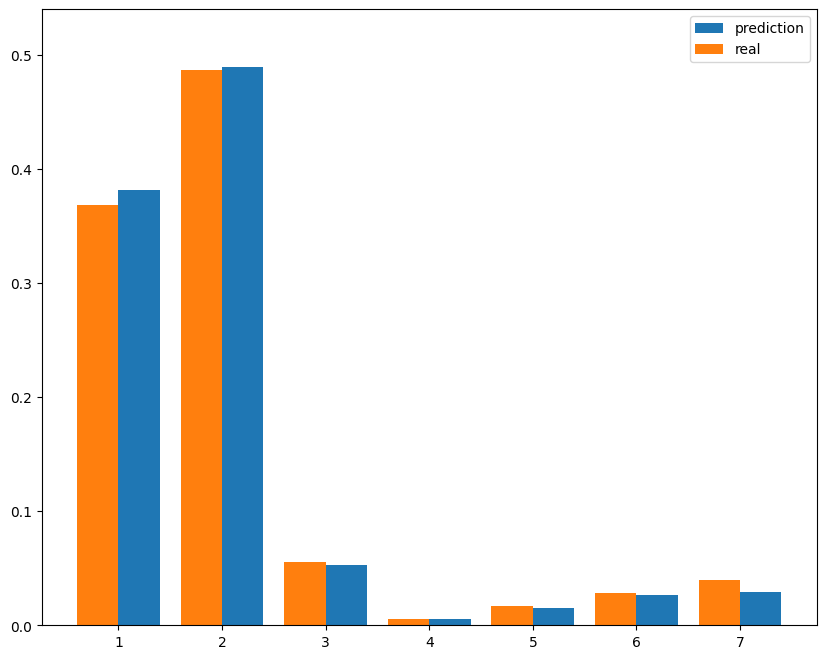

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

unique, freq = np.unique(test_labels, return_counts=True)
freq = list(map(lambda x: x / len(test_labels),freq))

pred_freq = pred_prob.mean(axis=0)
plt.figure(figsize=(10, 8))
plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label='prediction')
plt.bar(range(1, 8), freq, width=-0.4, align="edge", label='real')
plt.ylim(0, 0.54)
plt.legend()
plt.show()

## Conclusion

What is the quality of the model on the test sample? Compare it with the quality of logistic regression. Which model is better? Why? What are the pros and cons of the k Nearest Neighbors method? Plot the ROC curve for the k Nearest Neighbors method. Calculate the area under the ROC curve (AUC-ROC).

In [6]:

accuracy_score(test_labels, optimal_clf.predict(test_feature_matrix))

0.7845

In [7]:
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression(C=1, solver='liblinear')
clf1.fit(train_feature_matrix, train_labels)
accuracy_score(test_labels, clf1.predict(test_feature_matrix))

0.699

В данном случае точность у модели kNN оказалась выше, чем у логистической регрессии.


Логистическая регрессия:

Преимущества: Высокая скорость обучения и классификации, интерпретируемость.

Недостатки: Предполагает линейную зависимость между признаками и целевой переменной, плохо работает с нелинейными данными.
Подходит для задач с линейными границами классов, когда важна скорость и интерпретируемость модели.

KNN:
Подходит для задач с нелинейными границами классов, когда важна простота и скорость прототипирования.

Преимущества KNN:

- Простота реализации
- Отсутствие этапа обучения
- Может использоваться как для классификации, так и для регрессии.

Недостатки KNN:

- Вычисление расстояний до всех объектов обучающей выборки может быть ресурсоемким, особенно для больших наборов данных.
- Признаки с большим диапазоном значений могут доминировать над признаками с меньшим диапазоном. Необходима нормализация данных.
- Оптимальное значение K не всегда очевидно и требует настройки.
- Алгоритм может быть предвзятым по отношению к классам с большим количеством представителей.

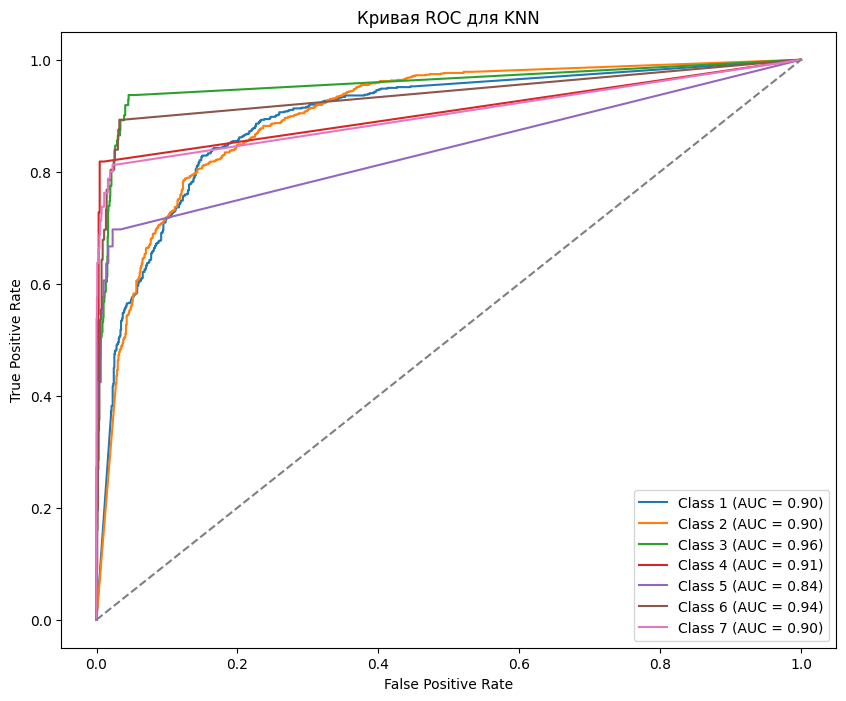

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


test_labels_bin = label_binarize(test_labels, classes=np.unique(labels))


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(labels))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(np.unique(labels))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Кривая ROC для KNN')
plt.legend()
plt.show()